Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [x] Begin with baselines for classification.
- [x] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [x] Make exploratory visualizations.
- [x] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Linear-Models/data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [7]:
from category_encoders import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Wrangle Data

In [8]:
def wrangle(filepath):
    # Load data downloaded from https://srcole.github.io/100burritos/
    df = pd.read_csv(filepath, 
                     parse_dates = ['Date'],
                     index_col = 'Date')
    
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale.
    # Drop unrated burritos.
    # Make binary classifications 0 and 1
    df = df.dropna(subset=['overall'])
    df['Great'] = df['overall'] >= 4
    df.loc[df['Great'] == True, 'Great'] = 1
    df.loc[df['Great'] == False, 'Great'] = 0

    # Clean/combine the Burrito categories
    df['Burrito'] = df['Burrito'].str.lower()

    california = df['Burrito'].str.contains('california')
    asada = df['Burrito'].str.contains('asada')
    surf = df['Burrito'].str.contains('surf')
    carnitas = df['Burrito'].str.contains('carnitas')

    df.loc[california, 'Burrito'] = 'California'
    df.loc[asada, 'Burrito'] = 'Asada'
    df.loc[surf, 'Burrito'] = 'Surf & Turf'
    df.loc[carnitas, 'Burrito'] = 'Carnitas'
    df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'
    
    # Drop some high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])
    
    # Drop some columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])
    
    # Replace all nan with 0
    df.replace(np.nan, 0, inplace = True)
    
    return df

df = wrangle(DATA_PATH+'burritos/burritos.csv')

In [9]:
# Write function that will replace X's in columns with 1

def replace_xs(columns):
    for col in columns:
        print('Currently working on:', col)
        df.loc[df[col] != 0, col] = 1
        df[col] = df[col].astype(int)

In [10]:
df.select_dtypes('object').columns

Index(['Burrito', 'Chips', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Egg',
       'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini'],
      dtype='object')

In [11]:
# Pick out names of columns to replace X's in.
# Won't use Burrito, because it is already in the format we want
columns_to_change = df.select_dtypes('object').columns[1:]

# Apply function to columns
replace_xs(columns_to_change)

Currently working on: Chips
Currently working on: Unreliable
Currently working on: NonSD
Currently working on: Beef
Currently working on: Pico
Currently working on: Guac
Currently working on: Cheese
Currently working on: Fries
Currently working on: Sour cream
Currently working on: Pork
Currently working on: Chicken
Currently working on: Shrimp
Currently working on: Fish
Currently working on: Rice
Currently working on: Beans
Currently working on: Lettuce
Currently working on: Tomato
Currently working on: Bell peper
Currently working on: Carrots
Currently working on: Cabbage
Currently working on: Sauce
Currently working on: Salsa.1
Currently working on: Cilantro
Currently working on: Onion
Currently working on: Taquito
Currently working on: Pineapple
Currently working on: Ham
Currently working on: Chile relleno
Currently working on: Nopales
Currently working on: Lobster
Currently working on: Egg
Currently working on: Mushroom
Currently working on: Bacon
Currently working on: Sushi
Curren

In [12]:
# Take a look at final df
df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,California,3.5,4.2,0,6.49,3.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
2016-01-24,California,3.5,3.3,0,5.45,3.5,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
2016-01-24,Carnitas,0.0,0.0,0,4.85,1.5,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
2016-01-24,Asada,0.0,0.0,0,5.25,2.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
2016-01-27,California,4.0,3.8,1,6.59,4.0,0.0,0.0,0.0,0.0,...,0,0.0,0,0,0,0,0,0,0,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Yelp            421 non-null    float64
 2   Google          421 non-null    float64
 3   Chips           421 non-null    int64  
 4   Cost            421 non-null    float64
 5   Hunger          421 non-null    float64
 6   Mass (g)        421 non-null    float64
 7   Density (g/mL)  421 non-null    float64
 8   Length          421 non-null    float64
 9   Circum          421 non-null    float64
 10  Volume          421 non-null    float64
 11  Tortilla        421 non-null    float64
 12  Temp            421 non-null    float64
 13  Meat            421 non-null    float64
 14  Fillings        421 non-null    float64
 15  Meat:filling    421 non-null    float64
 16  Uniformity      421 non-null    float64
 17  Salsa           

Code I used to come up with `replace_xs()` function.

In [14]:
#df.select_dtypes('object').info()

In [15]:
# df['Burrito'].unique()

Some visualizations with some of the features that will be included in feature matrix.

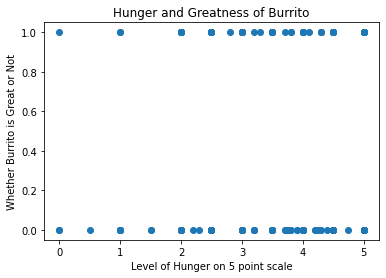

In [16]:
plt.scatter(df['Hunger'], df['Great'])
plt.xlabel('Level of Hunger on 5 point scale')
plt.ylabel('Whether Burrito is Great or Not')
plt.title('Hunger and Greatness of Burrito');

Based on the visualization above, linear regression will not be very useful. Logistic regression will be better, even more so, because I am tackling a classification problem.

## Split Data

In [17]:
# Split data into feature matrix and target vector
target = 'Great'
# dims_10 = ['Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 
#            'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
y = df[target]
X = df.drop(columns = target)

In [18]:
# Split the data into train, validate, and test sets
train_cutoff = '2017-01-01'
test_cutoff = '2017-12-31'
train_mask = X.index < train_cutoff
test_mask = X.index > test_cutoff
validate_mask = (X.index >= train_cutoff) & (X.index <= test_cutoff)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val, y_val = X.loc[validate_mask], y.loc[validate_mask]
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

## Establish Baseline

In [19]:
print('Baseline Accuracy Score:', y_train.value_counts(normalize = True).max())

Baseline Accuracy Score: 0.5906040268456376


## Build Model

In [20]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names = True), 
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(C = 0.6, max_iter = 500))

model_lr.fit(X_train, y_train)

/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Linear-Models/unit2venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Burrito'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.6, max_iter=500))])

## Check Metrics

In [21]:
print('Training Accuracy:', model_lr.score(X_train, y_train))
print('Validation Accuracy:', model_lr.score(X_val, y_val))
print('Test Accuracy:', model_lr.score(X_test, y_test))

Training Accuracy: 0.9194630872483222
Validation Accuracy: 0.7764705882352941
Test Accuracy: 0.7631578947368421


## Communicate Results

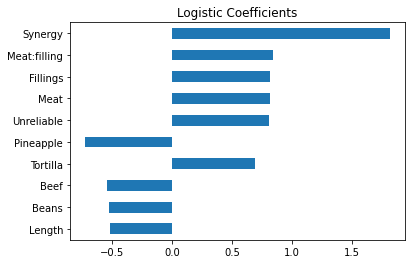

In [22]:
feature_names = model_lr.named_steps['onehotencoder'].get_feature_names()
coefficients = model_lr.named_steps['logisticregression'].coef_[0]
feature_importances = pd.Series(coefficients, index = feature_names).sort_values(key = abs)
feature_importances.tail(10).plot(kind = 'barh', title = 'Logistic Coefficients');